# k-Nearest Neighbors

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib

class StudentDataset: 
    def __init__(self, num_students: int, seed: int):
        
        self.num_students = num_students
        self.rng = np.random.default_rng(seed)
        self.df = self.assemble_dataframe()

    def generate_gender(self) -> list[str]:
        genders = ['Male', 'Female', 'Other']
        probabilities = [0.65, 0.33, 0.02]
        return self.rng.choice(genders, size=self.num_students, p=probabilities).tolist()

    def generate_major(self) -> list[str]:
        majors = ["B.Tech", "MS", "PhD"]
        probabilities = [0.7, 0.2, 0.1]
        return self.rng.choice(majors, size=self.num_students, p=probabilities).tolist()

    def generate_program(self, majors: list[str]) -> list[str]:
        programs = []
        for major in majors:
            if major == "B.Tech":
                programs.append(self.rng.choice(["CSE", "ECE", "CHD", "CND"], p = [0.4, 0.4, 0.1, 0.1]))
            elif major == "MS":
                programs.append(self.rng.choice(["CSE", "ECE", "CHD", "CND"], p = [0.3, 0.3, 0.2, 0.2]))
            elif major == "PhD":
                programs.append(self.rng.choice(["CSE", "ECE", "CHD", "CND"], p = [0.25, 0.25, 0.25, 0.25]))
            
        return programs
    
    def generate_gpa(self, majors: list[str]) -> list[float]:
        gpas = []
        for major in majors:
            if major == "B.Tech":
                gpa = self.rng.normal(7.0, 1.0)
            elif major == "MS":
                gpa = self.rng.normal(8.0, 0.7)
            elif major == "PhD":
                gpa = self.rng.normal(8.3, 0.5)

            gpas.append(np.clip(gpa, 4.0, 10.0))
        return gpas

    def assemble_dataframe(self) -> pd.DataFrame:
        majors = self.generate_major()
        programs = self.generate_program(majors)
        gpas = self.generate_gpa(majors)

        df = pd.DataFrame({
            "gender": self.generate_gender(),
            "major": majors,
            "program": programs,    
            "GPA": gpas
        })
        return df

    def get_full_dataframe(self) -> pd.DataFrame:
        return self.df

In [19]:
if __name__ == "__main__":
    username = "peketivenkata.v"
    seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2** 32)

    dataset = StudentDataset(num_students=10000, seed=seed)
    df = dataset.get_full_dataframe()
    print(df.head())

   gender   major program       GPA
0    Male  B.Tech     ECE  7.695391
1  Female      MS     CSE  8.403801
2    Male      MS     ECE  9.033050
3    Male     PhD     CND  7.932776
4  Female      MS     ECE  8.230006


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score


class PerFeatureTransformer:
    def __init__(self):
        self.transformers = {}

    def fit(self, df: pd.DataFrame, params: dict[str, str])-> None:
        """Fits transformers for each feature based on the given type.
        Parameters:
        df: The dataframe containing features to be transformed.
        params: A dictionary mapping feature name to
        transformation type,
        e.g., {"GPA": "standard", "major": "ordinal", "program":
        "onehot"}.
        """
        for feature, method in params.items():
            if method == 'standard':
                scaler = StandardScaler().fit(df[[feature]])
                self.transformers[feature] = ('standard', scaler)
            elif method == 'onehot':
                encoder = OneHotEncoder(sparse_output=False).fit(df[[feature]])
                self.transformers[feature] = ('onehot', encoder)
            elif method == 'ordinal':
                encoder = OrdinalEncoder().fit(df[[feature]])
                self.transformers[feature] = ('ordinal', encoder)
        
    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """Applies the fitted transformers to the corresponding features and returns a NumPy array."""
        transformed_data = []
        for feature, (method, transformer) in self.transformers.items():
            if method == 'standard':
                transformed_data.append(transformer.transform(df[[feature]]))
            elif method == 'onehot':
                transformed_data.append(transformer.transform(df[[feature]]))
            elif method == 'ordinal':
                transformed_data.append(transformer.transform(df[[feature]]))
        return np.hstack(transformed_data)
    
    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """Fits and transforms all features in one step using the given transformation parameters."""
        self.fit(df, params)
        return self.transform(df)

In [21]:
class KNNGenderPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str):
        """Initializes the predictor with the full student dataset."""
        self.df = student_df.copy()
        self.username = username
        self.transformer = PerFeatureTransformer()
        self.label_encoder = LabelEncoder()
        self.train_df = None
        self.val_df = None
        self.test_df = None

    def train_val_test_split(self, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42)-> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Splits the dataset into training, validation, and test sets with stratification"""
        # train_df, test_df = train_test_split(self.df, test_size=test_size, random_state=seed, stratify= self.df['gender'])
        # train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=seed, stratify= train_df['gender'])

        train_df, test_df = train_test_split(self.df, test_size=test_size, random_state=seed)
        train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=seed)
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        return train_df, val_df, test_df

    def get_feature_matrix_and_labels(self, df: pd.DataFrame, features: list[str], fit: bool = False, params: dict[str, str] = None) -> tuple[np.ndarray, np.ndarray]:
        """Extract selected features and gender labels from the DataFrame. 
        Applies encoding to categorical variables and normalizes numeric features. Does not fit encoders or scalers on test data. Only transforms using previously fitted ones."""

        feature_df = df[features].copy()

        if fit and params:
            # Fit and transform (for training set)
            X = self.transformer.fit_transform(feature_df, params)
            # Fit label encoder on training set
            y = self.label_encoder.fit_transform(df['gender'])
        else:
            # Only transform (for validation/test sets)
            X = self.transformer.transform(feature_df)
            # Transform using fitted label encoder
            y = self.label_encoder.transform(df['gender'])
        
        return X, y

    def get_knn_accuracy_vs_k(self, X_train, y_train, X_val, y_val, k_values: list[int], distance: str = "euclidean") -> list[float]:
        """Calculates accuracy scores for various k values on the validation set."""
        accs = []
        for k in k_values:
            model = KNeighborsClassifier(n_neighbors=k, metric=distance)
            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            accs.append(accuracy_score(y_val, preds)) #using accuracy here. Not f1_score
        return accs

    def plot_knn_accuracy_vs_k(self, k_values: list[int], accs: list[float], distance: str = "euclidean") -> None:
        """Plots accuracy scores against k values on the validation set."""
        plt.figure(figsize=(10, 6))
        plt.plot(k_values, accs, marker="o", linewidth=2, markersize=8)
        plt.xlabel("k (Number of Neighbors)")
        plt.ylabel("Validation Accuracy")
        plt.title(f"KNN Accuracy vs k ({distance} distance)")
        plt.grid(True, alpha=0.3)
        plt.xticks(k_values)
        
        plt.text(
            0.95, 0.95, "peketivenkata.v",  
            ha='right', va='top',
            transform=plt.gca().transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
        
        # Highlight best k
        best_k_idx = np.argmax(accs)
        best_k = k_values[best_k_idx]
        best_accuracy = accs[best_k_idx]
        plt.annotate(f'Best k={best_k}\nAccuracy={best_accuracy:.4f}', 
                    xy=(best_k, best_accuracy), xytext=(10, 10), 
                    textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', 
                    facecolor='yellow', alpha=0.7))
        
        plt.tight_layout()
        plt.show()

    def get_knn_f1_heatmap(self, X_train, y_train, X_val, y_val, k_values: list[int], distances: list[str]) -> pd.DataFrame:
        """Returns a dataframe with the f1-score for each combination on the validation set."""
        results = {}
        for dist in distances:
            scores = []
            for k in k_values:
                model = KNeighborsClassifier(n_neighbors=k, metric=dist)
                model.fit(X_train, y_train)
                preds = model.predict(X_val)
                scores.append(f1_score(y_val, preds, average="weighted"))  # Changed to weighted and using f1_score
            results[dist] = scores
        
        df = pd.DataFrame(results, index=k_values)
        return df

    def plot_knn_f1_heatmap(self, f1_scores_df: pd.DataFrame) -> None:
        """Plot F1 score heatmap for k values vs distance metrics."""
        plt.figure(figsize=(10, 8))
        sns.heatmap(f1_scores_df, annot=True, cmap="viridis", fmt='.5f',
                   cbar_kws={'label': 'F1 Score'})
        plt.title("F1 Score Heatmap (k vs Distance Metric)")
        plt.xlabel("Distance Metric")
        plt.ylabel("k (Number of Neighbors)")
        
        plt.text(0.95, 0.95, self.username, ha='right', va='top', 
                transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

    def get_knn_f1_single_feature_table(self, k_values: list[int], features: list[str], distance: str = "euclidean") -> pd.DataFrame:
        """Creates a table of F1 scores on the test set using only a single feature for prediction."""
        if self.train_df is None or self.test_df is None:
            raise ValueError("Must call train_val_test_split() first")
        
        results = {}
        
        for feature in features:
            # Create new transformer for each feature
            feature_transformer = PerFeatureTransformer()
            feature_label_encoder = LabelEncoder()
            
            # Assign the transformation for the feature
            if feature == "GPA":
                params = {"GPA": "standard"}
            elif feature == "major":
                params = {"major": "ordinal"}
            elif feature == "program":
                params = {"program": "onehot"}
            else:
                # Default
                params = {feature: "standard"}
            
            # Get training data for single feature (fit and transform)
            X_train = feature_transformer.fit_transform(self.train_df[[feature]], params)
            y_train = feature_label_encoder.fit_transform(self.train_df['gender'])
            
            # Get test data for single feature (transform only)
            X_test = feature_transformer.transform(self.test_df[[feature]])
            y_test = feature_label_encoder.transform(self.test_df['gender'])
            
            scores = []
            for k in k_values:
                model = KNeighborsClassifier(n_neighbors=k, metric=distance)
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                scores.append(f1_score(y_test, preds, average="weighted"))
            
            results[feature] = scores
        
        df = pd.DataFrame(results, index=k_values)
        return df
    


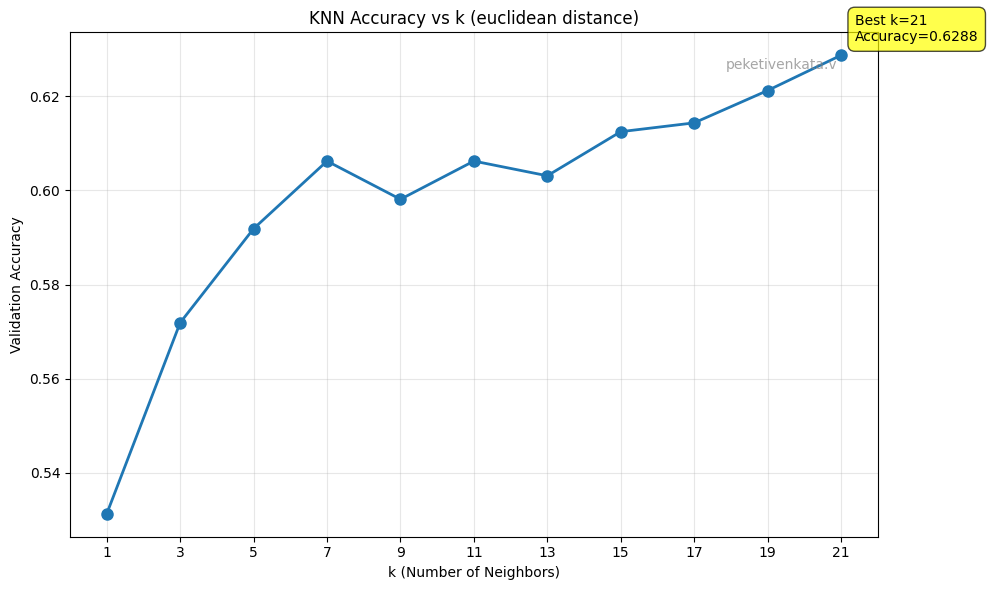

In [22]:
if __name__ == "__main__":

    predictor = KNNGenderPredictor(student_df=df, username="peketivenkata.v")

    train_df, val_df, test_df = predictor.train_val_test_split()

    features = ["GPA", "major", "program"]
    params = {"GPA": "standard", "major": "ordinal", "program": "onehot"}

    X_train, y_train = predictor.get_feature_matrix_and_labels(train_df, features, fit=True, params=params)
    X_val, y_val = predictor.get_feature_matrix_and_labels(val_df, features)
    X_test, y_test = predictor.get_feature_matrix_and_labels(test_df, features)

    k_values = list(range(1, 22, 2))
    accs1 = predictor.get_knn_accuracy_vs_k(X_train, y_train, X_val, y_val, k_values, distance="euclidean")
    predictor.plot_knn_accuracy_vs_k(k_values, accs1, distance="euclidean")


K = 21 gave the highest accuracy  on the validation set with Euclidean distance metric

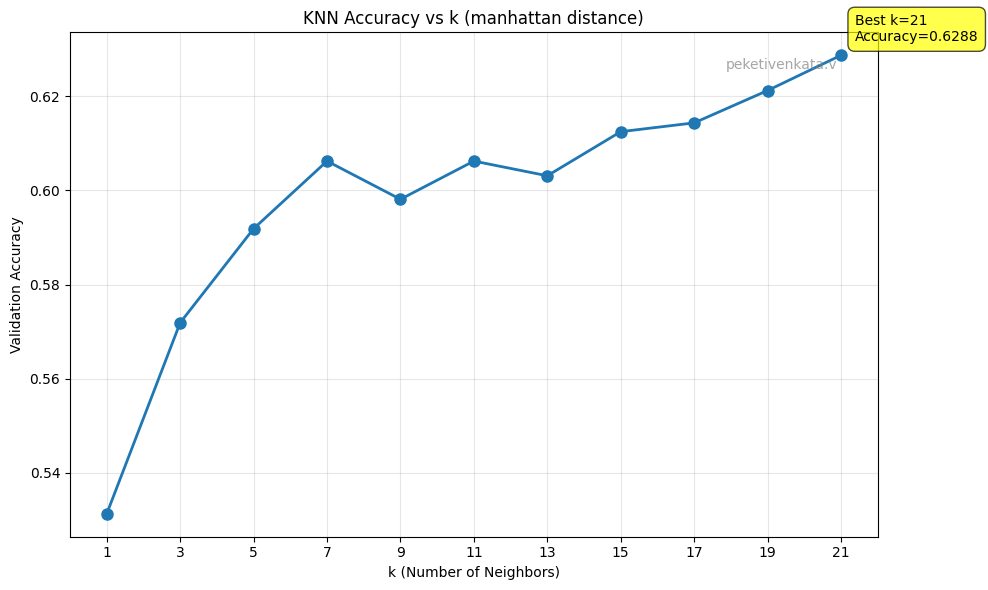

In [23]:
accs2 = predictor.get_knn_accuracy_vs_k(X_train, y_train, X_val, y_val, k_values, distance="manhattan")
predictor.plot_knn_accuracy_vs_k(k_values, accs2, distance="manhattan")

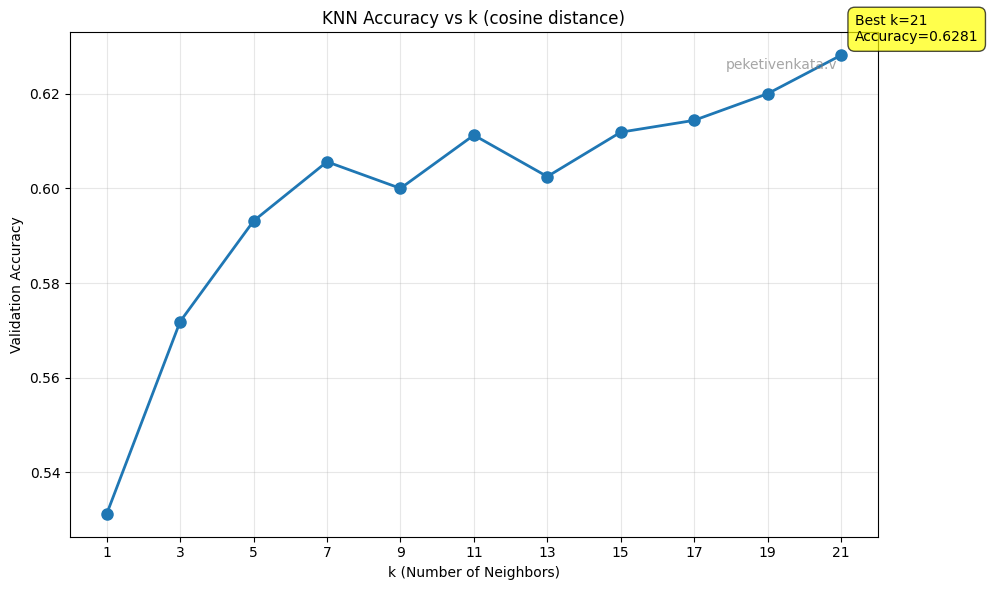

In [24]:
accs3 = predictor.get_knn_accuracy_vs_k(X_train, y_train, X_val, y_val, k_values, distance="cosine")
predictor.plot_knn_accuracy_vs_k(k_values, accs3, distance="cosine")



    euclidean  manhattan    cosine
1    0.532554   0.532554  0.532554
3    0.561626   0.561626  0.561626
5    0.568868   0.568868  0.569835
7    0.574927   0.574927  0.574454
9    0.556255   0.556255  0.557600
11   0.556198   0.556198  0.562687
13   0.549146   0.549146  0.549247
15   0.552654   0.552654  0.552232
17   0.545977   0.545977  0.545343
19   0.545268   0.545268  0.544475
21   0.543354   0.543354  0.543719


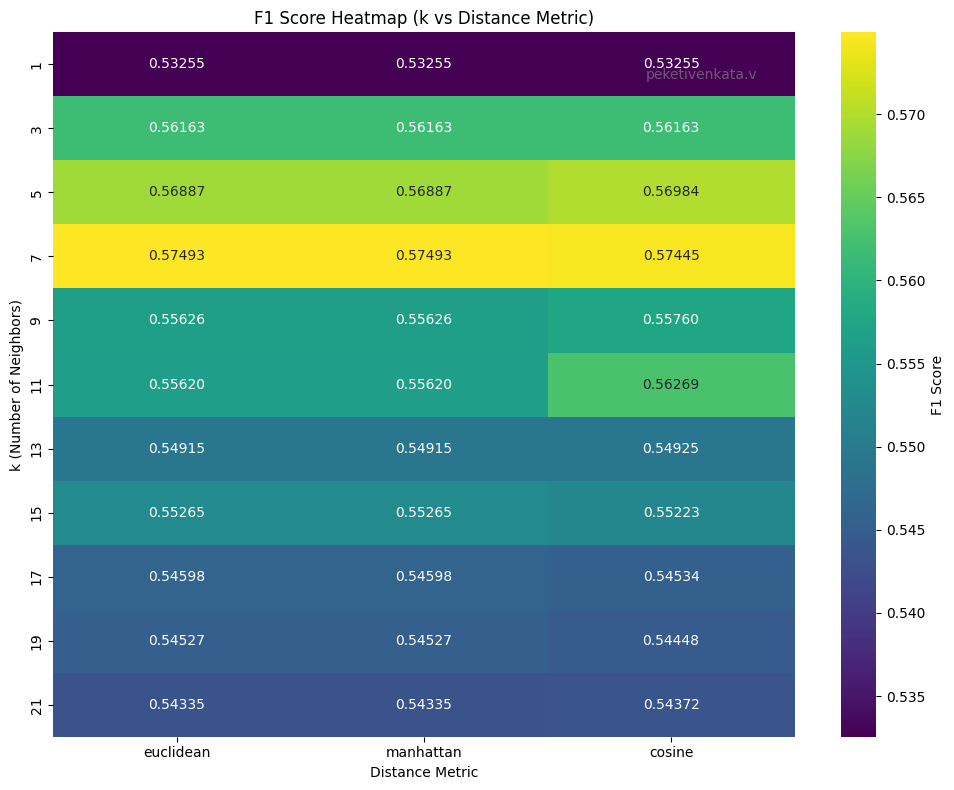

In [25]:
distances = ["euclidean", "manhattan", "cosine"]
f1_df = predictor.get_knn_f1_heatmap(X_train, y_train, X_val, y_val, k_values, distances)
print(f1_df)
predictor.plot_knn_f1_heatmap(f1_df)

Im my case euclidean and manhattan results are almost exactly the same. Also since we are standardizing all the features have a similar scale and also even after feature transform i.e after they are converted into one-hot or ordinal we still have low feature dimentions. And for low dimension features both the manhattan and euclidian performs similar. The Euclidean distance is just a strictly increasing transform of the Manhattan distance. Strictly increasing transforms preserve orderings, so the nearest neighbors are identical and KNN outputs and also the F1 SCORES coincide. And also the cosine performs very similar and the difference is very minute. 

In [26]:
per_feature_f1_df_1 = predictor.get_knn_f1_single_feature_table(k_values, features, distance="euclidean")
print("Single Feature F1 Score Table (Euclidean Distance):")
#predictor.plot_knn_f1_heatmap(per_feature_f1_df_1)

print(per_feature_f1_df_1)

Single Feature F1 Score Table (Euclidean Distance):
         GPA     major   program
1   0.533718  0.558611  0.551906
3   0.535674  0.556763  0.551906
5   0.544947  0.558611  0.551906
7   0.535482  0.558611  0.561209
9   0.549004  0.556763  0.569192
11  0.564444  0.556763  0.569192
13  0.557344  0.556763  0.527369
15  0.561969  0.556763  0.527369
17  0.556799  0.556763  0.551906
19  0.557093  0.556763  0.551906
21  0.545855  0.527369  0.527369


In [27]:
per_feature_f1_df_2 = predictor.get_knn_f1_single_feature_table(k_values, features, distance="manhattan")
print("Single Feature F1 Score Table (Manhattan Distance):")
#predictor.plot_knn_f1_heatmap(per_feature_f1_df_2)

print(per_feature_f1_df_2)

Single Feature F1 Score Table (Manhattan Distance):
         GPA     major   program
1   0.533718  0.558611  0.551906
3   0.535674  0.556763  0.551906
5   0.544947  0.558611  0.551906
7   0.535482  0.558611  0.561209
9   0.549004  0.556763  0.569192
11  0.564444  0.556763  0.569192
13  0.557344  0.556763  0.527369
15  0.561969  0.556763  0.527369
17  0.556799  0.556763  0.551906
19  0.557093  0.556763  0.551906
21  0.545855  0.527369  0.527369


In [28]:
per_feature_f1_df_3 = predictor.get_knn_f1_single_feature_table(k_values, features, distance="cosine")
print("Single Feature F1 Score Table (Cosine Distance):")
#predictor.plot_knn_f1_heatmap(per_feature_f1_df_3)
print(per_feature_f1_df_3)

Single Feature F1 Score Table (Cosine Distance):
         GPA     major   program
1   0.156005  0.558611  0.527369
3   0.485161  0.558611  0.527369
5   0.527369  0.558611  0.527369
7   0.527369  0.558611  0.527369
9   0.527369  0.558611  0.527369
11  0.527369  0.558611  0.527369
13  0.519864  0.558611  0.527369
15  0.519864  0.156005  0.527369
17  0.519864  0.156005  0.527369
19  0.527369  0.156005  0.527369
21  0.527369  0.156005  0.527369


### Using Heat-Maps for the above for better visualization
**Note:** using the same method(plot_knn_f1_heatmap) defined in the class for previous question, so the title X axis labelling might be wrong. Just using the heatmap for better visualization and it is not asked in the question :P

Single Feature F1 Score Table (Euclidean Distance):


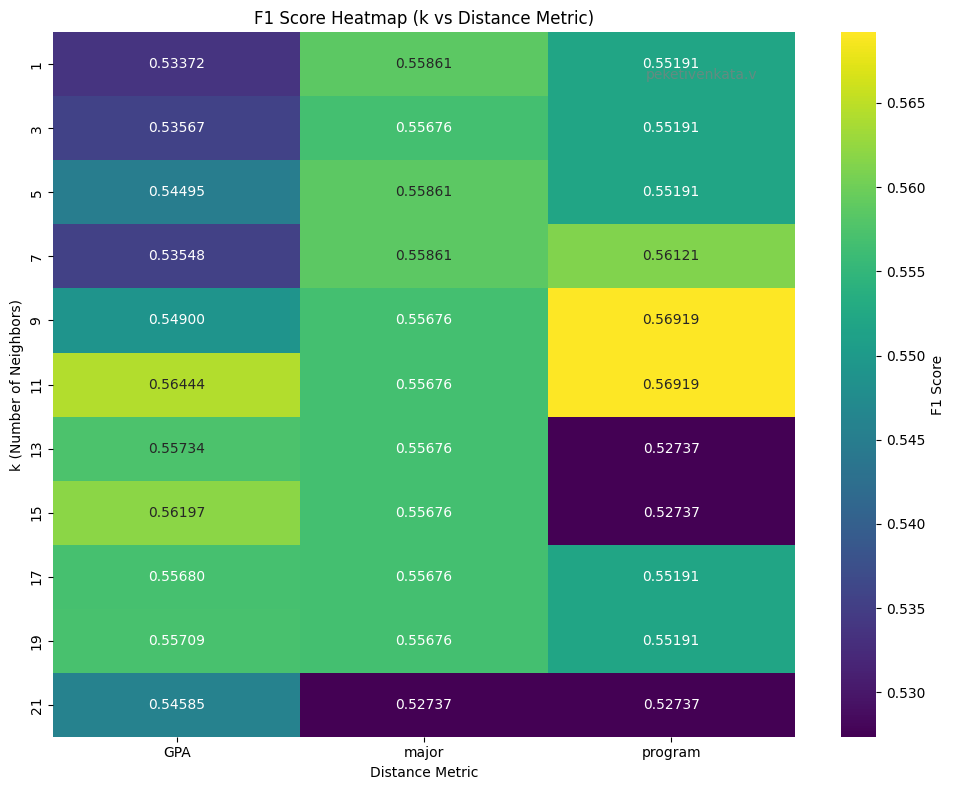

Single Feature F1 Score Table (Manhattan Distance):


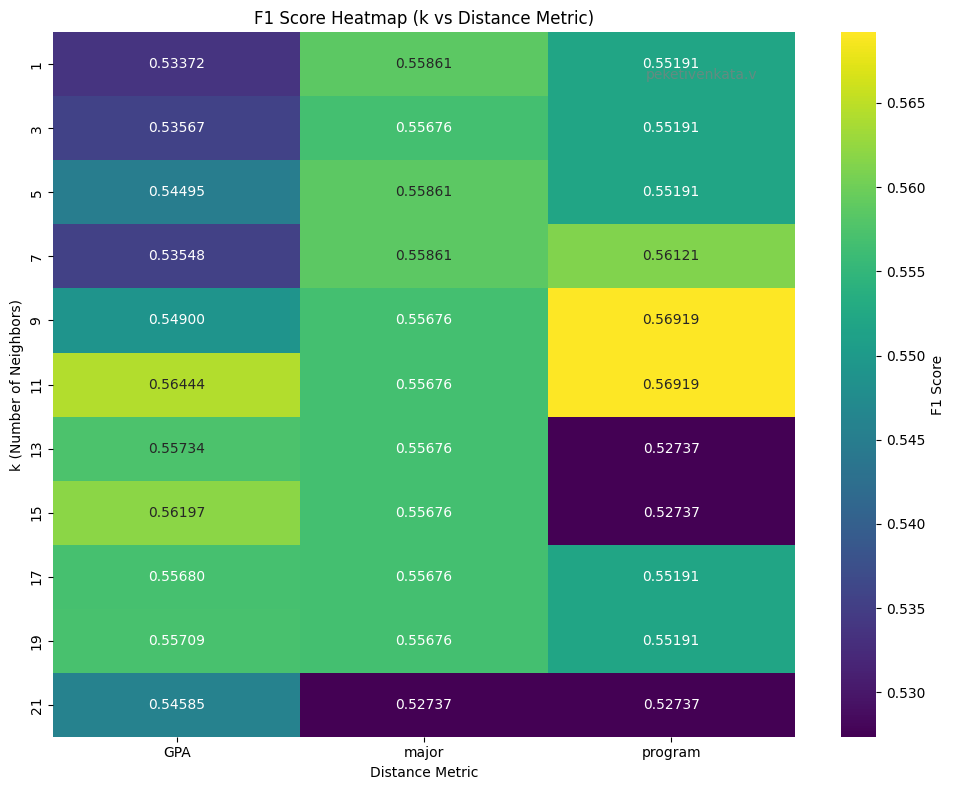

Single Feature F1 Score Table (Cosine Distance):


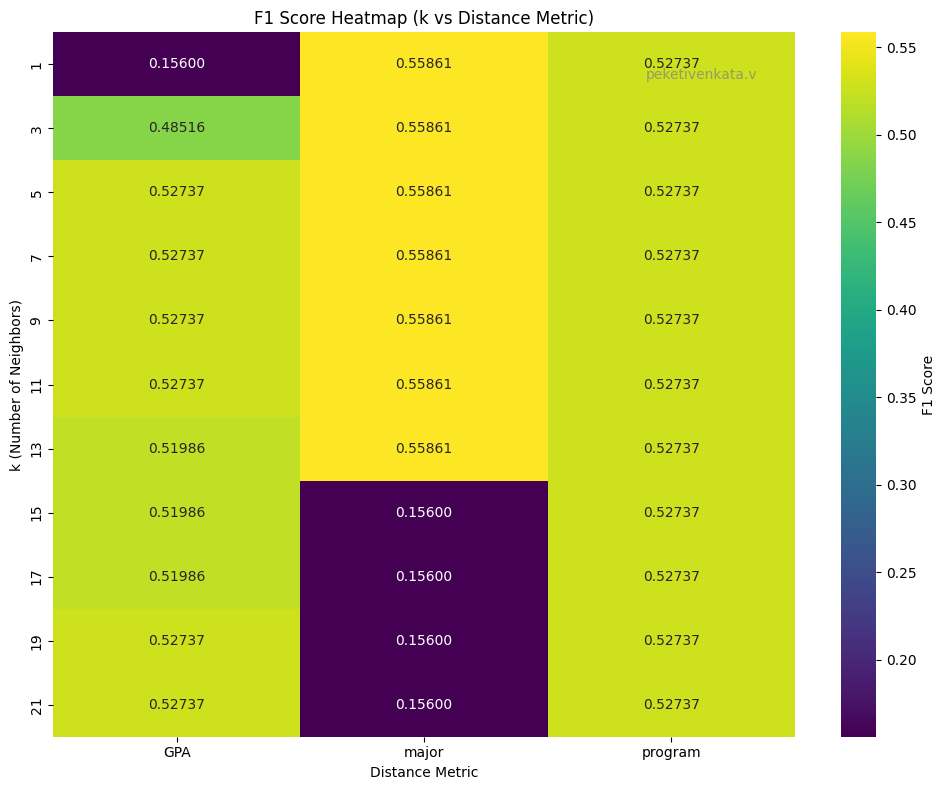

In [29]:
print("Single Feature F1 Score Table (Euclidean Distance):")
predictor.plot_knn_f1_heatmap(per_feature_f1_df_1)

print("Single Feature F1 Score Table (Manhattan Distance):")
predictor.plot_knn_f1_heatmap(per_feature_f1_df_2)

print("Single Feature F1 Score Table (Cosine Distance):")
predictor.plot_knn_f1_heatmap(per_feature_f1_df_3)

For K = 9 to 11 in case of euclidian and manhattan 'Program' seems to perform the best. And in the case of cosine till K = 13 'major' seems to perform better. But overall as we can see in all the 3 distance metrics, 'GPA' seems to be consistent even though not the highest and in case of euclidian and manhattan all the three seems to perform quite similar and consistent. When we use all features together, the F1 scores are consistently better or equal compared to using any single feature alone.
However, the gap between the best single feature and using all features is not very large.

One key takeaway is even when we are using all the features and even for single features almost all the f1 scores are quite similar. This suggests that gender is not strongly correlated with any single feature "GPA", "Major", or "Program" and this is indeed true even intuitivly. There’s no clear pattern or trend in the data that strongly links these features to gender, which explains why the F1 scores remain close regardless of the metric or feature used.